In [18]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook, tnrange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Data Loading
### Some input parameters


In [4]:
DATA_PATH = '/home/bohdan/histologie/data/dataset/'
IMG_WIDTH = 5760
IMG_HEIGHT = 3840
DESIRED_IMG_HEIGHT = 1024


### Useful functions for loading and resizing training images

In [13]:
def proper_img_resize(img, img_width=1024):
    """
    Resizing an image by saving aspect ratio
    """
    w_percent = (img_width / float(img.size[0]))
    hsize = int((float(img.size[1])*float(w_percent)))
    return np.asarray(img.resize((img_width,hsize), PIL.Image.ANTIALIAS))

def load_data(path, train=True):
    ids = next(os.walk(os.path.join(path,'images')))[2][:3]
    X = np.zeros((len(ids), 682,DESIRED_IMG_HEIGHT,3), dtype=np.float32)
    if train:
        y = np.zeros((len(ids),682, DESIRED_IMG_HEIGHT, 3), dtype=np.float32)
    print('Getting and resizing images ...')
    
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(os.path.join(path, 'images',id_))
        x_img = proper_img_resize(img, img_width=DESIRED_IMG_HEIGHT)
        
        # Load masks
        if train:
            mask = load_img(os.path.join(path,'masks', id_))
            mask = proper_img_resize(mask, img_width=DESIRED_IMG_HEIGHT)
        
        # NORMALIZATION
        X[n,...] = x_img / 255
        
        if train:
            y[n] = mask / 255
    
    print("Done!")

    if train:
        return X, y

    return X
X, y  = load_data(DATA_PATH, train=True)

  0%|          | 0/3 [00:00<?, ?it/s]

Getting and resizing images ...
(5760, 3840)
(5760, 3840)


 33%|███▎      | 1/3 [00:01<00:03,  1.87s/it]

(5760, 3840)
(5760, 3840)


 67%|██████▋   | 2/3 [00:03<00:01,  1.85s/it]

(5760, 3840)
(5760, 3840)


100%|██████████| 3/3 [00:05<00:00,  1.91s/it]

Done!


In [41]:
# Data splitting
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=2018)

### Check if training data looks okay

(-0.5, 1023.5, 681.5, -0.5)

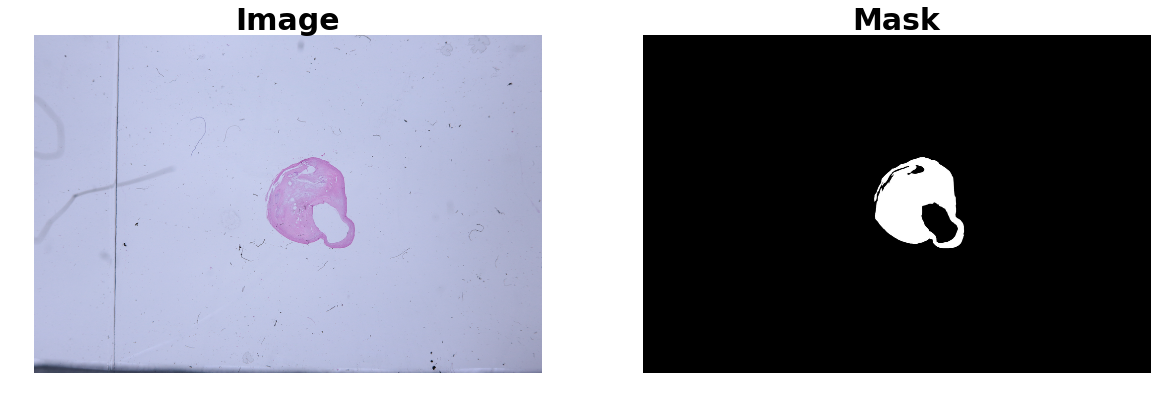

In [42]:
ind = 1
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(X_train[ind])
plt.title("Image",fontsize=30,fontweight='bold')
plt.axis("Off")

plt.subplot(1,2,2)
plt.imshow(y_train[ind])
plt.title("Mask", fontsize=30, fontweight='bold')
plt.axis("Off")

# Building Unet Model

In [45]:
def conv2d_block(input_tensor, n_filters, kernel_size=3,batchnorm=True):
    #first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), 
               kernel_initializer="he_normal", padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    #second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
              kernel_initializer="he_normal", padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    
    x = Activation("relu")(x)
    
    return x

def Unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropout*0.5)(p1)
    
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2,2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3,3), strides=(2,2), padding="same") (c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(n_filters*4, (3,3), strides=(2,2), padding="same") (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(n_filters*2, (3,3), strides=(2,2), padding="same") (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1,1), activation="sigmoid") (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [47]:
X_train.shape

(2, 682, 1024, 3)

In [48]:
input_img = Input((682, 1024, 3), name='img')

model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

ValueError: `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 84, 128, 128), (None, 85, 128, 128)]